## Dictionary Learning con datos meteorológicos

Se ha pedido lo siguiente a Gemini AI:

"I want you to write a python code using the skit-learn api dictionary learning doing the following: 
1) import a dataset related to metheorology (whatever you can obtain which has interest, for example from an URL, assure that you can access): suggest me a dataset easily available. 
2) learn a sparse dictionary and a sparse representation with the mentioned api 
3) comment what you are doing 
4) Give an interpretation of all the results obtained (in terms of metheorology) 
5) Give all the coefficients in a matrix
Do it such that it is computationally feasible 

Posteriormente se han hecho algunas modificaciones a la hora de preguntar para que aporte toda la información con todo lujo de detalles:

Añade más explicación a la hora de imprimir y tal, y si puedes generar algún gráfico, y añade el significado de cada átomo"

La IA ha optado por usar una base de datos correspondientes a ciertos datos climatológicos de la ciudad de Seattle con las columnas: date,precipitation,temp_max,temp_min,wind,weather, correspondientes a todo el año 2012. El script de Python es

 [OK] Dataset cargado: 1461 registros meteorológicos encontrados.

 DICCIONARIO DE PATRONES APRENDIDOS (Significado Físico)
                                          precipitation  temp_max  temp_min  \
Átomo 0: Lluvioso/Húmedo & Frío/Invernal           4.03     11.32      4.97   
Átomo 1: Lluvioso/Húmedo                           9.52     15.67      8.21   
Átomo 2: Cálido/Soleado                            2.42     18.47      9.29   
Átomo 3: Frío/Invernal                             2.36     12.23      4.94   

                                          wind  
Átomo 0: Lluvioso/Húmedo & Frío/Invernal  3.62  
Átomo 1: Lluvioso/Húmedo                  3.54  
Átomo 2: Cálido/Soleado                   1.90  
Átomo 3: Frío/Invernal                    2.55  

--------------------------------------------------------------------------------


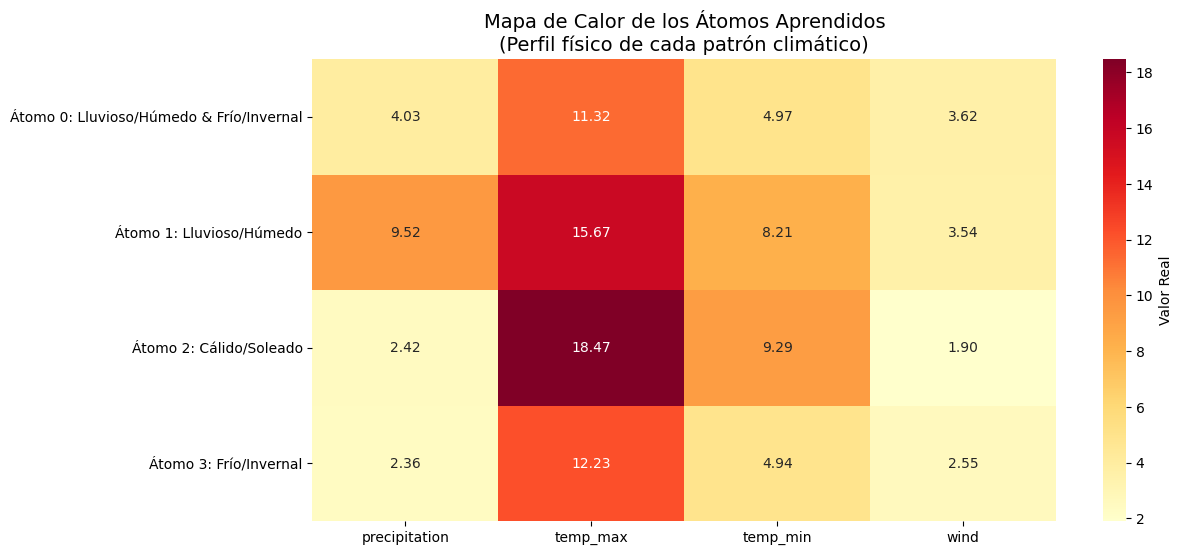

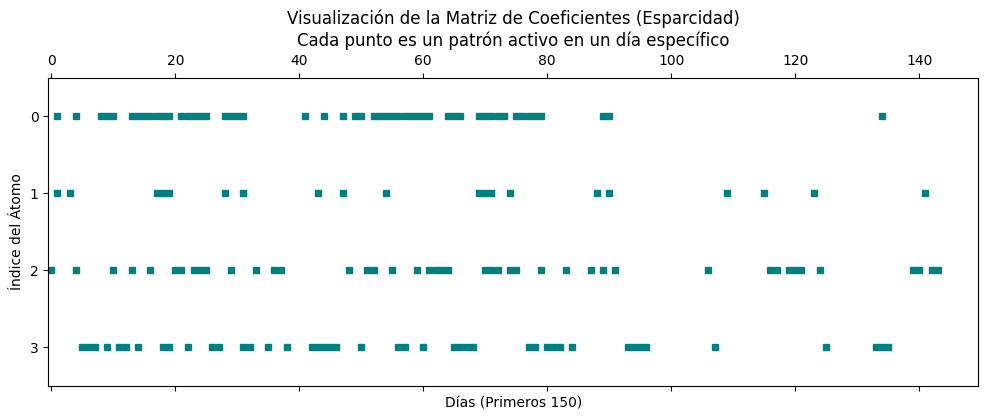


 MATRIZ DE COEFICIENTES (H) - REPRESENTACIÓN ESPARSA (Primeros 15 días)
        A0      A1      A2      A3
0   0.0000  0.0000 -0.1784  0.0000
1   0.5951  0.2528  0.0000  0.0000
2   0.0000  0.0000  0.0000  0.0000
3   0.0000  1.7898  0.0000  0.0000
4   0.1725  0.0000 -1.2424  0.0000
5   0.0000  0.0000  0.0000  1.0838
6   0.0000  0.0000  0.0000  0.7913
7   0.0000  0.0000  0.0000  0.6730
8   0.1438  0.0000  0.0000  0.0000
9   0.7844  0.0000  0.0000  0.2454
10  1.3853  0.0000 -0.1302  0.0000
11  0.0000  0.0000  0.0000  1.5993
12  0.0000  0.0000  0.0000  2.0291
13  1.3311  0.0000 -0.3405  0.0000
14  1.5782  0.0000  0.0000  0.6037

 [INFO] Nivel de esparcidad: 74.69% de la matriz son ceros.
 [INFO] Interpretación: Cada día se explica mediante una combinación simple de estos átomos.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import DictionaryLearning
from sklearn.preprocessing import StandardScaler

# ==========================================
# 1) IMPORTACIÓN Y PREPARACIÓN DEL DATASET
# ==========================================
url = "https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv"

try:
    data = pd.read_csv(url)
    features = ['precipitation', 'temp_max', 'temp_min', 'wind']
    # Eliminamos filas con nulos y nos quedamos con las columnas numéricas
    X_raw = data[features].dropna()
    print(f" [OK] Dataset cargado: {X_raw.shape[0]} registros meteorológicos encontrados.\n")
except Exception as e:
    print(f" [ERROR] No se pudo acceder a los datos: {e}")
    exit()

# Escalado: Fundamental para que unidades distintas (mm vs °C) sean comparables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# =========================================================
# 2) APRENDIZAJE DE DICCIONARIO (DICTIONARY LEARNING)
# =========================================================
# n_components=4: Definimos 4 "estados climáticos" fundamentales (átomos)
# alpha=1: Controla la escasez (sparsity). A mayor alpha, más ceros en la matriz.
n_atoms = 4
dict_learner = DictionaryLearning(
    n_components=n_atoms, 
    alpha=1.0, 
    transform_algorithm='lasso_lars', 
    random_state=42,
    max_iter=1000
)

# sparse_representation (H): Cómo se compone cada día (coeficientes)
# dictionary_atoms (D): Qué características definen cada patrón
sparse_representation = dict_learner.fit_transform(X_scaled)
dictionary_atoms = dict_learner.components_

# =========================================================
# 3) INTERPRETACIÓN Y ETIQUETADO DE RESULTADOS
# =========================================================
# Revertimos el escalado para entender los átomos en unidades reales
interpreted_atoms = scaler.inverse_transform(dictionary_atoms)
df_atoms = pd.DataFrame(interpreted_atoms, columns=features)

def asignar_nombre_meteorologico(row):
    """Asigna un nombre lógico basado en los valores físicos del átomo."""
    labels = []
    if row['precipitation'] > 3: labels.append("Lluvioso/Húmedo")
    if row['temp_max'] > 18: labels.append("Cálido/Soleado")
    if row['temp_min'] < 6: labels.append("Frío/Invernal")
    if row['wind'] > 4.2: labels.append("Ventoso")
    
    return " & ".join(labels) if labels else "Estable/Despejado"

nombres_logicos = [f"Átomo {i}: {asignar_nombre_meteorologico(row)}" for i, row in df_atoms.iterrows()]
df_atoms.index = nombres_logicos

print("="*80)
print(" DICCIONARIO DE PATRONES APRENDIDOS (Significado Físico)")
print("="*80)
print(df_atoms.round(2))
print("\n" + "-"*80)

# =========================================================
# 4) VISUALIZACIÓN DE RESULTADOS
# =========================================================
# Gráfico 1: Heatmap de los Átomos
plt.figure(figsize=(12, 6))
sns.heatmap(df_atoms, annot=True, cmap="YlOrRd", fmt=".2f", cbar_kws={'label': 'Valor Real'})
plt.title("Mapa de Calor de los Átomos Aprendidos\n(Perfil físico de cada patrón climático)", fontsize=14)
plt.show()

# Gráfico 2: Esparcidad de la Matriz de Coeficientes
plt.figure(figsize=(12, 4))
plt.spy(sparse_representation[:150].T, precision=0.01, aspect='auto', marker='s', markersize=4, color='teal')
plt.title("Visualización de la Matriz de Coeficientes (Esparcidad)\nCada punto es un patrón activo en un día específico", fontsize=12)
plt.ylabel("Índice del Átomo")
plt.xlabel("Días (Primeros 150)")
plt.show()

# =========================================================
# 5) MATRIZ DE COEFICIENTES (H) COMPLETA (Muestra)
# =========================================================
print("\n" + "="*80)
print(" MATRIZ DE COEFICIENTES (H) - REPRESENTACIÓN ESPARSA (Primeros 15 días)")
print("="*80)
# Creamos un DataFrame para que sea legible
h_matrix_display = pd.DataFrame(sparse_representation, columns=[f"A{i}" for i in range(n_atoms)])
print(h_matrix_display.head(15).round(4))

# Cálculo de Sparsity Final
sparsity_pct = np.mean(sparse_representation == 0) * 100
print(f"\n [INFO] Nivel de esparcidad: {sparsity_pct:.2f}% de la matriz son ceros.")
print(" [INFO] Interpretación: Cada día se explica mediante una combinación simple de estos átomos.")